#  XGB Model

In [7]:
import datetime
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from joblib import dump, load  # for saving models

In [8]:
# !pip install GPUtil

In [9]:
from automl import *

In [10]:
import gc
import GPUtil

In [11]:
# MANIFEST - list of versions on board 
import sys
import os
print(pd.datetime.now())
print('OS: '+os.uname().sysname)
print('Python: '+sys.version)
print('matplotlib: '+mpl.__version__)
print('numpy: '+np.__version__)
print('pandas: '+pd.__version__)
print('sklearn: '+sklearn.__version__)
print('xgboost: '+xgb.__version__)

2020-02-19 09:54:07.400940
OS: Linux
Python: 3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
matplotlib: 3.1.3
numpy: 1.18.1
pandas: 1.0.1
sklearn: 0.22.1
xgboost: 0.90


/home/user/anaconda3/envs/lgbm/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [12]:
# https://askubuntu.com/questions/5417/how-to-get-the-gpu-info
# might want to conditinally set the 'tree_method' parameter to xbgoost based on the return to this call
# ! lspci  -v -s  $(lspci | grep ' VGA ' | cut -d" " -f 1) | grep 'controller'

## Data Prep

In [13]:
FOLDER = '../mortality_prediction_docker_model/v2/scratch/'
train_file = FOLDER+'train_all.csv.gz'
train = pd.read_csv(train_file,low_memory = False)
train.shape

(278998, 227)

In [14]:
train.head()

,race_concept_id,ethnicity_concept_id,race_concept_name,person_id,visit_duration,death_in_next_window,number_of_visits,gender_concept_id,old,visit_concept_name,...,observation_concept_id_list_40757059,observation_concept_id_list_4081756,observation_concept_id_list_4176605,observation_concept_id_list_4186037,observation_concept_id_list_4192270,observation_concept_id_list_4214956,observation_concept_id_list_43021378,observation_concept_id_list_4305831,observation_concept_id_list_433942,observation_type_concept_id_list_38000282
0,8552.0,NaN,Unknown,0,0,0,4,8507,84.0,0,...,0,0,0,0,0,1,0,0,0,1
1,8557.0,NaN,Native Hawaiian or Other Pacific Islander,5,0,0,1,8507,72.0,1,...,0,0,0,0,0,0,0,0,0,0
2,8527.0,NaN,White,6,0,0,3,8532,31.0,0,...,0,0,0,0,0,0,0,0,0,1
3,8552.0,38003564.0,Unknown,10,0,0,1,8532,71.0,0,...,0,0,0,0,0,0,0,0,0,0
4,8516.0,NaN,Black or African American,12,0,0,2,8532,88.0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
cols = pd.DataFrame([[c.split('_')[-1] for c in train.columns],train.columns]).T
cols.columns =['concept_id','column']
cols.concept_id[0:21] = 0 # the first are strings
cols.concept_id = cols.concept_id.astype(int)
cols.iloc[20:25]

,concept_id,column
20,0,condition_concept_id_list_140214
21,192279,condition_concept_id_list_192279
22,194686,condition_concept_id_list_194686
23,195588,condition_concept_id_list_195588
24,197381,condition_concept_id_list_197381


In [16]:
all_concepts = pd.read_csv('v2/app/concept_codes_final/all_concepts.csv')
all_concepts.head()

,concept_id,concept_name,vocabulary_id,table
0,3000453,Epstein Barr virus DNA [#/volume] (viral load)...,LOINC,measurement
1,3000515,Antithrombin actual/normal in Platelet poor pl...,LOINC,measurement
2,3000722,Carnitine free (C0) [Moles/volume] in Serum or...,LOINC,measurement
3,3001405,CD3+CD8+ (T8 suppressor cells) cells [#/volume...,LOINC,measurement
4,3001599,Carotene [Mass/volume] in Serum,LOINC,measurement


In [17]:
col_concepts = cols.set_index('concept_id').join(all_concepts.set_index('concept_id'), how='left')
col_concepts.head()

,column,concept_name,vocabulary_id,table
concept_id,,,,
0,race_concept_id,NaN,NaN,NaN
0,ethnicity_concept_id,NaN,NaN,NaN
0,race_concept_name,NaN,NaN,NaN
0,person_id,NaN,NaN,NaN
0,visit_duration,NaN,NaN,NaN


In [18]:
col_concepts.tail()

,column,concept_name,vocabulary_id,table
concept_id,,,,
40483287,condition_concept_id_list_40483287,Disorder of kidney and/or ureter,SNOMED,condition_occurrence
40757059,observation_concept_id_list_40757059,NaN,NaN,NaN
43011909,drug_concept_id_list_43011909,NaN,NaN,NaN
43021378,observation_concept_id_list_43021378,Suspected infectious disease,SNOMED,observation
43531028,condition_concept_id_list_43531028,Mononeuropathy of lower limb,SNOMED,condition_occurrence


In [19]:
# What % oc concept_id's don't have a corresponding concept code?
round(col_concepts.isnull().sum().table / col_concepts.shape[0], 2)*100

54.0

In [20]:
all_concepts[all_concepts.concept_id == 38000200]

,concept_id,concept_name,vocabulary_id,table


In [21]:
start_mem = train.memory_usage().sum() / 1024**2
print('Memory usage is {:.2f} MB'.format(start_mem))

Memory usage is 483.19 MB


In [22]:
train = cols_toint(train)

In [23]:
%%time
train = reduce_mem_usage(train)

Memory usage of dataframe is 483.19 MB
Memory usage after optimization is: 66.52 MB
Decreased by 86.2%
CPU times: user 6.42 s, sys: 1.64 s, total: 8.06 s
Wall time: 8.07 s


In [24]:
train.head()

,race_concept_id,ethnicity_concept_id,race_concept_name,person_id,visit_duration,death_in_next_window,number_of_visits,gender_concept_id,old,visit_concept_name,...,observation_concept_id_list_40757059,observation_concept_id_list_4081756,observation_concept_id_list_4176605,observation_concept_id_list_4186037,observation_concept_id_list_4192270,observation_concept_id_list_4214956,observation_concept_id_list_43021378,observation_concept_id_list_4305831,observation_concept_id_list_433942,observation_type_concept_id_list_38000282
0,8552.0,0.0,Unknown,0,0,False,4,8507,84,0,...,False,False,False,False,False,True,False,False,False,True
1,8560.0,0.0,Native Hawaiian or Other Pacific Islander,5,0,False,1,8507,72,1,...,False,False,False,False,False,False,False,False,False,False
2,8528.0,0.0,White,6,0,False,3,8532,31,0,...,False,False,False,False,False,False,False,False,False,True
3,8552.0,38003564.0,Unknown,10,0,False,1,8532,71,0,...,False,False,False,False,False,False,False,False,False,False
4,8512.0,0.0,Black or African American,12,0,False,2,8532,88,0,...,False,False,False,False,False,False,False,False,False,False


In [25]:
# %%time
# # expensive, don't do this if you don't have time
# find_dup_cols(train)

In [26]:
# # there are no duplicates
# train_nodup = train.drop_duplicates()
# train_nodup.shape

In [27]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train.race_concept_name = train.race_concept_name.replace(to_replace=0, value='Unknown')
train.race_concept_name = train.race_concept_name.fillna('Unknown')
label_encoder = label_encoder.fit(train.race_concept_name)
train.race_concept_name = label_encoder.transform(train.race_concept_name)

In [28]:
train_describe_df = train.describe(include='all').T.fillna('')
train_describe_df[:30]

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
race_concept_id,278998.0,,,,,,0,8512,8528,8560,8656
ethnicity_concept_id,278998.0,,,,2.12587e+07,1.88731e+07,0,0,3.80036e+07,3.80036e+07,3.80036e+07
race_concept_name,278998.0,,,,2.70562,1.66763,0,1,3,4,5
person_id,278998.0,,,,75818.2,43668.1,0,38065,75703,113636,151684
visit_duration,278998.0,,,,0.695471,3.33994,0,0,0,0,138
death_in_next_window,278998.0,2,False,278439,,,,,,,
number_of_visits,278998.0,,,,3.97358,9.90562,1,1,2,3,465
gender_concept_id,278998.0,,,,8521.07,12.4016,8507,8507,8532,8532,8532
old,278998.0,,,,72.0547,12.5964,0,67,73,80,101
visit_concept_name,278998.0,,,,0.608965,1.69431,0,0,0,1,65


In [29]:
train.shape

(278998, 227)

In [30]:
# select features
drop_features = ['death_in_next_window', 'window_id', 'person_id']

X = train.drop(drop_features, axis = 1)
train_features = X.columns.values
y = train.death_in_next_window
X = np.array(X)
y = np.array(y).ravel()

## Test 

In [31]:
test_file = FOLDER+'test_all.csv.gz'
test = pd.read_csv(test_file,low_memory = False)
test.shape

(118781, 227)

In [32]:
test = cols_toint(test)
test.shape

(118781, 227)

In [33]:
test.race_concept_name = test.race_concept_name.replace(to_replace=0, value='Unknown')
test.race_concept_name = test.race_concept_name.fillna('Unknown')
test.race_concept_name = label_encoder.transform(test.race_concept_name)

In [34]:
X_test = test.drop(drop_features, axis = 1)
X_test = X_test[train_features]  # order the test columns like train
test_features = X_test.columns.values
X_test = np.array(X_test)

In [35]:
y_test = test.death_in_next_window

## XGB Model

In [70]:
imbalance = int(round(train.shape[0] / train.death_in_next_window.sum()))
random_state = 1234
num_round = 500
early_stop = round(num_round / 5)  # 20% of the full rounds
metrics = ['auc']                   # faster with fewer metrics to calc
metrics = ['aucpr','error', 'auc']

params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': metrics,
    'tree_method' : 'gpu_hist',  # set to 'auto' if no gpu - other options 'gpu_hist', 'hist', 'exact'
    'random_state' : random_state,
    'reg_lambda' : 1.0,
    'min_child_weight' : 1.0,
    'max_bin' : 256,
    'min_split_loss' : 0.01,
    'max_depth' : 15,
    'reg_alpha' : 0.0,
    'colsample_bylevel' : 1.0,
    'scale_pos_weight' : 500,
    'max_delta_step' : 0.0,
    'learning_rate' : 0.05,
    'n_estimators' : 1000,
    'num_parallel_tree' : 1,
    'colsample_bytree' : 0.7,
    'subsample' : 1.0,
    'missing': 0,
}

In [75]:
# from sklearn.model_selection import StratifiedShuffleSplit

# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)

# for train_index, valid_index in sss.split(X, y):
#     X_train, X_valid = X[train_index], X[valid_index]
#     y_train, y_valid = y[train_index], y[valid_index]

In [33]:
imbalance = int(round(train.shape[0] / train.death_in_next_window.sum()))
random_state = 1234
num_round = 500
early_stop = round(num_round / 5)  # 20% of the full rounds
metrics = 'auc'                   # faster with fewer metrics to calc
# metrics = ['aucpr','error', 'auc']

params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': metrics,
    'tree_method' : 'gpu_hist',  # set to 'auto' if no gpu - other options 'gpu_hist', 'hist', 'exact'
    'random_state' : random_state,
    'scale_pos_weight' : imbalance,
    'missing': 0,
    'subsample': 0.8,
}
#     'reg_lambda' : 1.0,
#     'min_child_weight' : 1.0,
#     'max_bin' : 256,
#     'min_split_loss' : 0.01,
#     'max_depth' : 10,
#     'reg_alpha' : 0.0,
#     'colsample_bylevel' : 1.0,
#     'scale_pos_weight' : 1.0,
#     'max_delta_step' : 0.0,
#     'learning_rate' : 0.05,
#     'n_estimators' : 1000,
#     'num_parallel_tree' : 1,
#     'colsample_bytree' : 0.5,
#     'subsample' : 1.0,
#     'n_jobs': -1.0,

xgb_model = xgb.XGBClassifier(**params)
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=0, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1234,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=499, seed=None,
              silent=None, subsample=0.8, tree_method='gpu_hist', verbosity=1)

In [122]:
# %%time

# window = {}
# for w in train.window_id.unique():
#     X = train[train.window_id == w]
#     y = X.death_in_next_window
#     window[w] = {'size': y.shape[0], 'deaths': y.sum()}
#     X = X.drop(drop_features, axis = 1)
#     train_features = X.columns.values
#     X = np.array(X)
#     y = np.array(y).ravel()
#     cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
#     cv_scores = {}
#     for i, (train_index, valid_index) in enumerate(cv.split(X, y)):
#         X_train, X_valid = X[train_index], X[valid_index]
#         y_train, y_valid = y[train_index], y[valid_index]
#         watchlist = [(X_train, y_train), (X_valid, y_valid)]

#         if w > 0:
#             booster = xgb_model.get_booster()
#         else: 
#             booster = None
            
#         xgb_model.fit(X_train, y_train,
#                       eval_set=watchlist, eval_metric=metrics,
#                       early_stopping_rounds=early_stop, verbose=False,
#                       xgb_model = booster,
#                       callbacks=[ xgb_progressbar(num_round),])

#         cv_scores[i] = {'best_score': xgb_model.best_score, 
#                         'best_iteration': xgb_model.best_iteration, 
#                         'best_ntree_limit': xgb_model.best_ntree_limit,
#                         'evals_result': xgb_model.evals_result()}

#         print("Best Score:%f, best iteration:%d, best ntree:%d" % 
#               (xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))
#         window[w].update(cv_scores)

In [37]:
# %%time
drop_features = ['death_in_next_window', 'window_id', 'person_id']
window = {}
xgb_model = None # clear out the xgb_model
for w in train.window_id.unique():
    X = train[train.window_id == w] #[train.columns[:50]].copy()
    y = train[train.window_id == w].death_in_next_window
    window[w] = {'size': y.shape[0], 'deaths': y.sum()}
    X = X.drop(drop_features, axis=1)
    train_features = X.columns.values
    X = np.array(X)
    y = np.array(y).ravel()
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
    cv_scores = {}
    for i, (train_index, valid_index) in enumerate(cv.split(X, y)):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        evals_result ={}
        # Convert our data into XGBoost format
        d_train = xgb.DMatrix(X_train, y_train, feature_names=train_features)
        d_valid = xgb.DMatrix(X_valid, y_valid,  feature_names=train_features)
        watchlist = [(d_train, 'train'), (d_valid, 'valid')]

        xgb_model = xgb.train(params=params, dtrain=d_train, num_boost_round=num_round, 
                              evals=watchlist, evals_result=evals_result, 
                              early_stopping_rounds=early_stop, verbose_eval=False,
                              xgb_model= xgb_model,
                              callbacks=[ xgb_progressbar(num_round),]) # use either the progress bar or the plot
                                         # plot_perf_i(evals_result)]) 
        cv_scores[i] = {'best_score': xgb_model.best_score, 
                        'best_iteration': xgb_model.best_iteration, 
                        'best_ntree_limit': xgb_model.best_ntree_limit,
                        'evals_result': evals_result}

        print("Best Score:%f, best iteration:%d, best ntree:%d" % 
              (xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))
        window[w].update(cv_scores)
        GPUtil.showUtilization()
        gc.collect()

Best Score:0.720442, best iteration:56, best ntree:57
| ID | GPU | MEM |
------------------
|  0 | 47% | 19% |



Best Score:0.720442, best iteration:56, best ntree:57
| ID | GPU | MEM |
------------------
|  0 | 45% | 19% |



Best Score:0.720442, best iteration:56, best ntree:57
| ID | GPU | MEM |
------------------
|  0 | 39% | 19% |



Best Score:0.720442, best iteration:56, best ntree:57
| ID | GPU | MEM |
------------------
|  0 | 45% | 20% |



Best Score:0.720442, best iteration:56, best ntree:57
| ID | GPU | MEM |
------------------
|  0 | 48% | 19% |



Best Score:0.720442, best iteration:56, best ntree:57
| ID | GPU | MEM |
------------------
|  0 | 46% | 20% |



Best Score:0.720442, best iteration:56, best ntree:57
| ID | GPU | MEM |
------------------
|  0 | 56% | 20% |



Best Score:0.720442, best iteration:56, best ntree:57
| ID | GPU | MEM |
------------------
|  0 | 33% | 20% |



Best Score:0.720442, best iteration:56, best ntree:57
| ID | GPU | MEM |
------------------
|  0 | 49% | 20% |



Best Score:0.720442, best iteration:56, best ntree:57
| ID | GPU | MEM |
------------------
|  0 | 53% | 20% |



Best Score:0.720442, best iteration:56, best ntree:57
| ID | GPU | MEM |
------------------
|  0 | 48% | 19% |



Best Score:0.720442, best iteration:56, best ntree:57
| ID | GPU | MEM |
------------------
|  0 | 54% | 20% |



Best Score:0.720442, best iteration:56, best ntree:57
| ID | GPU | MEM |
------------------
|  0 | 54% | 19% |



Best Score:0.720442, best iteration:56, best ntree:57
| ID | GPU | MEM |
------------------
|  0 | 41% | 19% |



Best Score:0.720442, best iteration:56, best ntree:57
| ID | GPU | MEM |
------------------
|  0 | 33% | 19% |



Best Score:0.720442, best iteration:56, best ntree:57
| ID | GPU | MEM |
------------------
|  0 | 52% | 19% |



Best Score:0.720442, best iteration:56, best ntree:57
| ID | GPU | MEM |
------------------
|  0 | 54% | 19% |



Best Score:0.720442, best iteration:56, best ntree:57
| ID | GPU | MEM |
------------------
|  0 | 52% | 19% |



In [160]:
# select features
drop_features = ['death_in_next_window', 'person_id'] # 'window_id', 

X = train[train.columns[:50]].drop(['death_in_next_window','person_id'], axis = 1)
train_features = X.columns.values
y = train[['death_in_next_window']]
X = np.array(X)
y = np.array(y).ravel()

In [161]:
%%time
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
cv_scores = {}
for i, (train_index, valid_index) in enumerate(cv.split(X, y)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    window['0'] = {'size': y.shape[0], 'deaths': y.sum()}
    evals_result ={}
    # Convert our data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train, feature_names=train_features)
    d_valid = xgb.DMatrix(X_valid, y_valid,  feature_names=train_features)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    xgb_model = xgb.train(params=params, dtrain=d_train, num_boost_round=num_round, 
                          evals=watchlist, evals_result=evals_result, 
                          early_stopping_rounds=early_stop, verbose_eval=False,
                          callbacks=[ xgb_progressbar(num_round),]) # use either the progress bar or the plot
                                     # plot_perf_i(evals_result)]) 
    cv_scores[i] = {'best_score': xgb_model.best_score, 
                    'best_iteration': xgb_model.best_iteration, 
                    'best_ntree_limit': xgb_model.best_ntree_limit,
                    'evals_result': evals_result}

    print("Best Score:%f, best iteration:%d, best ntree:%d" % 
          (xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))


Best Score:0.733771, best iteration:4, best ntree:5



Best Score:0.735456, best iteration:4, best ntree:5


Best Score:0.746480, best iteration:3, best ntree:4
CPU times: user 11.9 s, sys: 904 ms, total: 12.8 s
Wall time: 12.7 s


In [116]:
# window = {}
# window[0] = {'size': y.shape[0], 'deaths': y.sum()}
# window[0].update(cv_scores)
# window[1] = {'size': y.shape[0], 'deaths': y.sum()}
# window[1].update(cv_scores)

In [38]:
# prep a df to plot the learning curve
w_df = pd.DataFrame(window)
w_df.loc['cv_av_score'] = 0
w_df.loc['cum_size'] = 0

for j in w_df.columns:
    cv_av_score = 0
    for i in [0,1,2]:
        cv_av_score += w_df.loc[i,j]['best_score']
    cv_av_score = cv_av_score / 3
    w_df.loc['cv_av_score',j] = cv_av_score
w_df

for j in w_df.columns:
    if j != 0:
        w_df.loc['cum_size',j] = w_df.loc['size',j] + w_df.loc['cum_size',j-1] 
    else:
        w_df.loc['cum_size',j] = w_df.loc['size',j]

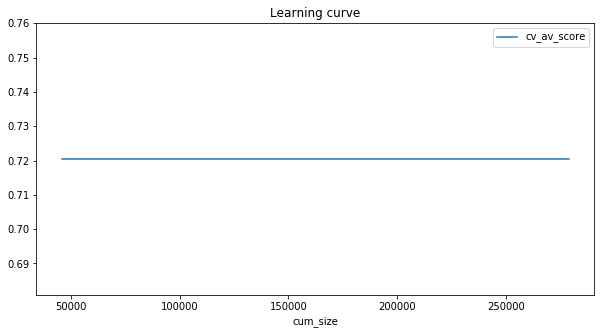

In [39]:
ax = w_df.T.plot(x='cum_size', y='cv_av_score', figsize=(10,5), title='Learning curve')

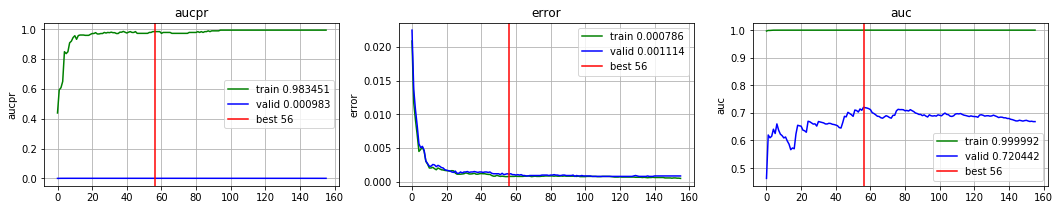

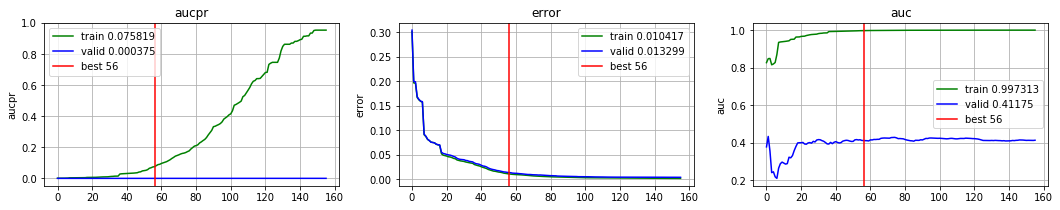

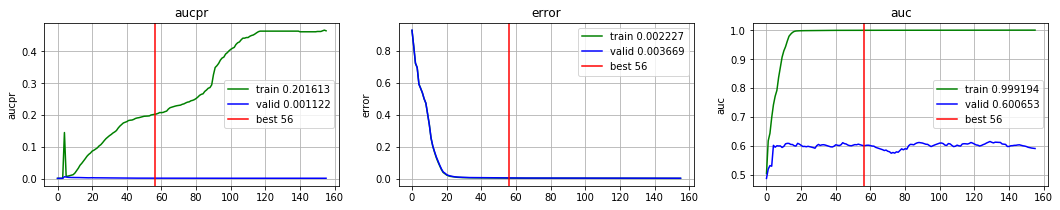

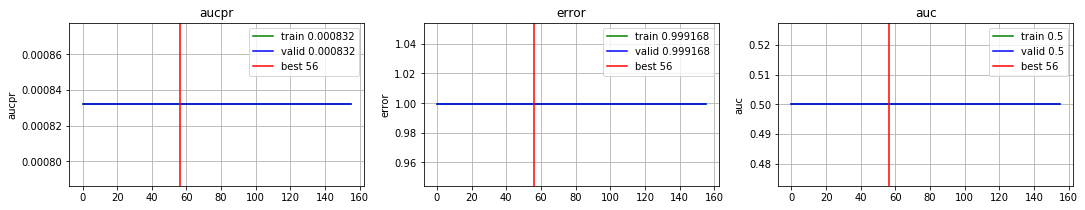

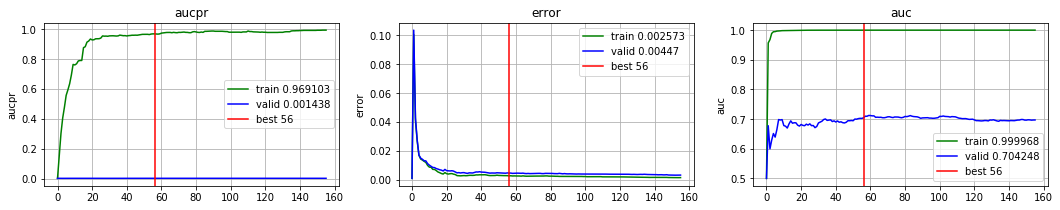

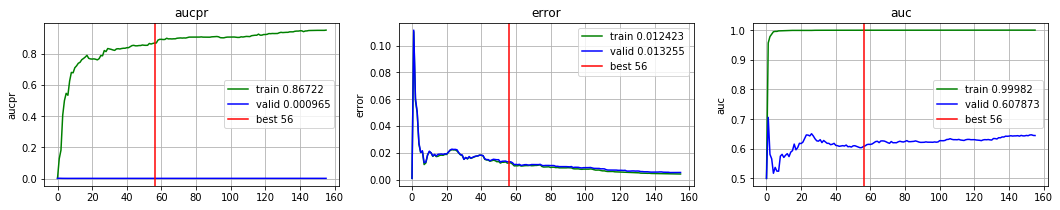

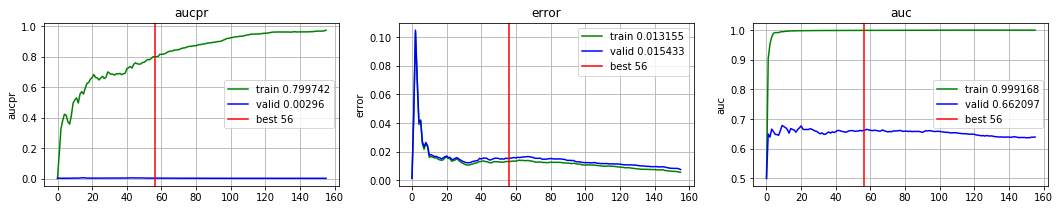

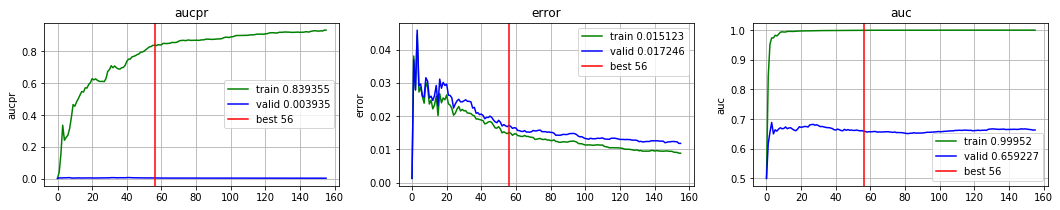

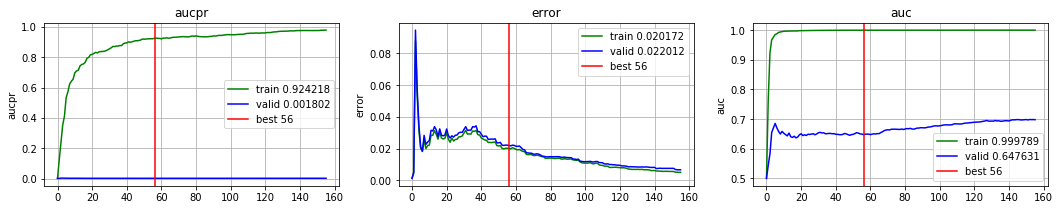

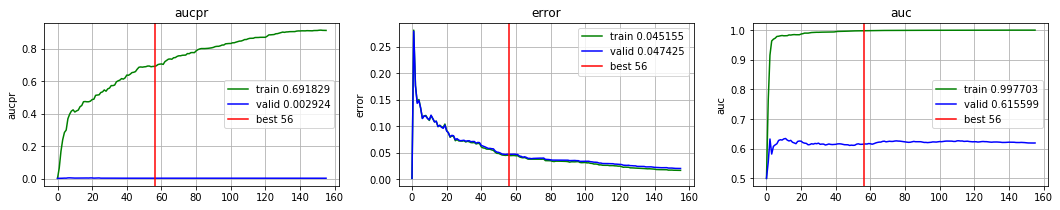

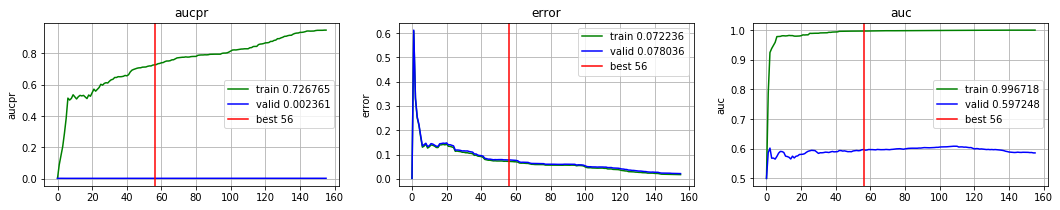

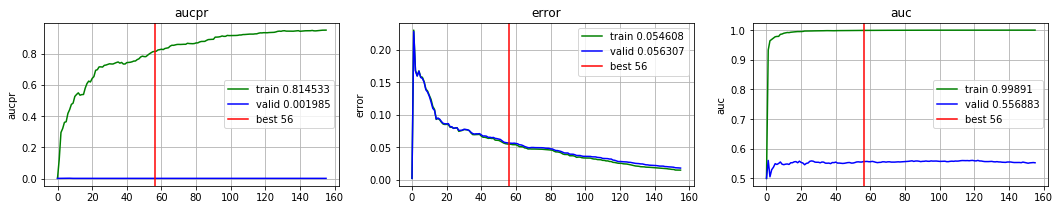

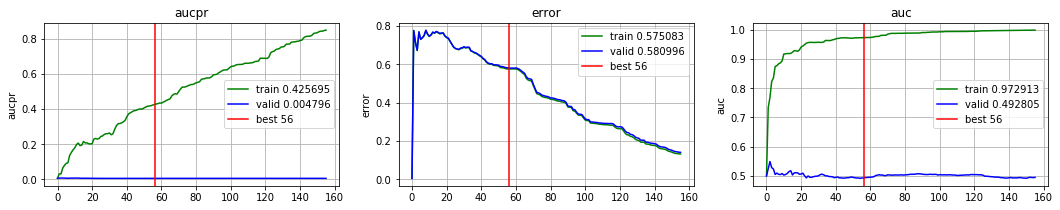

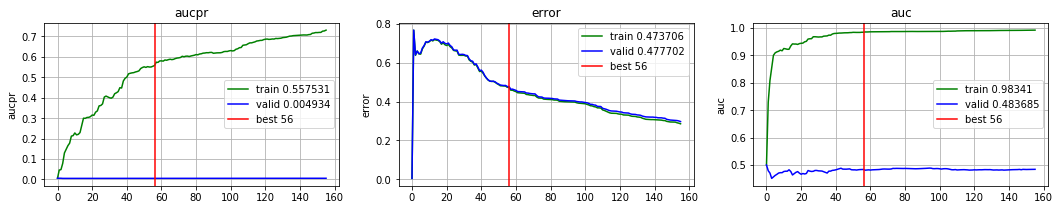

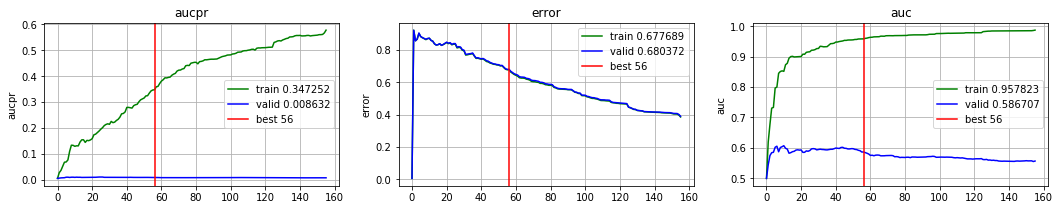

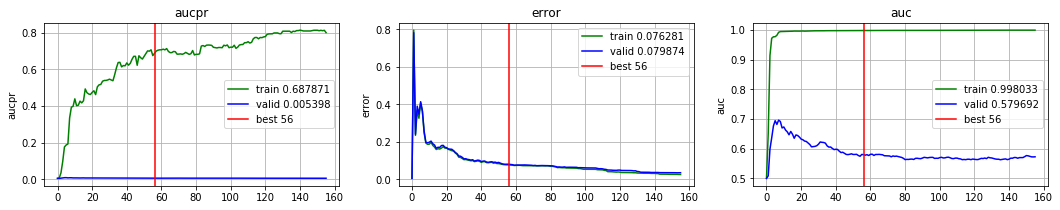

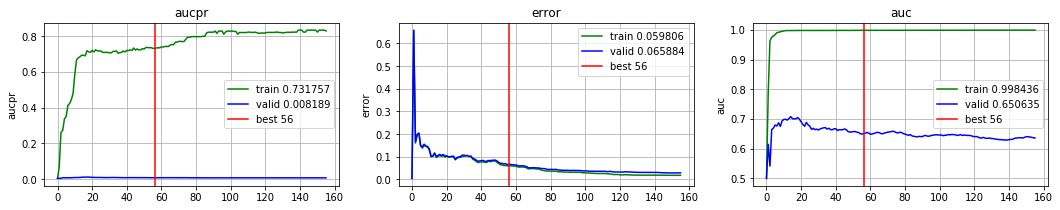

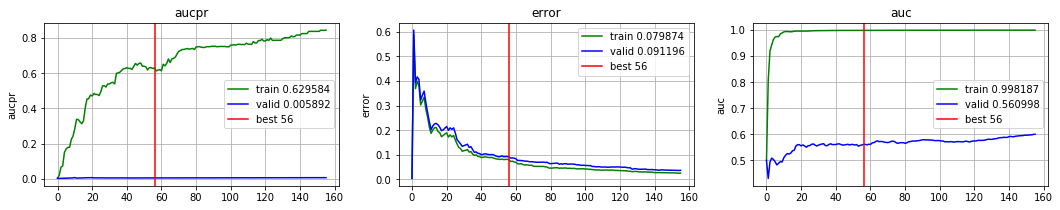

In [40]:
for w in w_df.columns:
    for i in [0,1,2]:
        plot_perf(w_df.loc[i,w]['evals_result'], w_df.loc[i,w]['best_iteration'])

In [60]:
# select features
drop_features = ['death_in_next_window', 'window_id', 'person_id'] 

X = train.drop(drop_features, axis = 1)
train_features = X.columns.values
y = train.death_in_next_window
X = np.array(X)
y = np.array(y).ravel()

In [82]:
# %%time
# another way to calc CV, but no model is returned or retained
#
d_train = xgb.DMatrix(X, y, feature_names=train_features)

cv_scores = xgb.cv(params=params, dtrain=d_train, num_boost_round=num_round, nfold=3, stratified=True,
                    metrics=metrics, early_stopping_rounds=early_stop, verbose_eval=False,
                    callbacks=[ xgb_progressbar(num_round),])
cv_scores

,train-auc-mean,train-auc-std,train-aucpr-mean,train-aucpr-std,train-error-mean,train-error-std,test-auc-mean,test-auc-std,test-aucpr-mean,test-aucpr-std,test-error-mean,test-error-std
0,0.861147,0.017304,0.100319,0.010709,0.340739,0.019136,0.544025,0.010475,0.002389,0.000173,0.344139,0.017819
1,0.921240,0.010915,0.174291,0.025012,0.249091,0.009812,0.554953,0.020612,0.002492,0.000392,0.251744,0.008471
2,0.937952,0.010109,0.213685,0.021140,0.240882,0.036443,0.561515,0.017585,0.002678,0.000480,0.242693,0.034976
3,0.940983,0.010241,0.218955,0.025373,0.220116,0.043128,0.563930,0.015095,0.002541,0.000342,0.222618,0.041948
4,0.948294,0.011588,0.263514,0.024969,0.215512,0.049095,0.562129,0.015343,0.002494,0.000280,0.217726,0.047387
...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.999828,0.000025,0.938355,0.007371,0.005489,0.000497,0.564831,0.012925,0.002726,0.000153,0.008208,0.000312
496,0.999828,0.000025,0.938487,0.007272,0.005482,0.000490,0.564844,0.012993,0.002727,0.000153,0.008190,0.000318
497,0.999828,0.000025,0.938513,0.007314,0.005479,0.000492,0.564832,0.012890,0.002725,0.000153,0.008179,0.000330
498,0.999829,0.000025,0.938547,0.007266,0.005469,0.000488,0.565053,0.012962,0.002727,0.000154,0.008201,0.000339


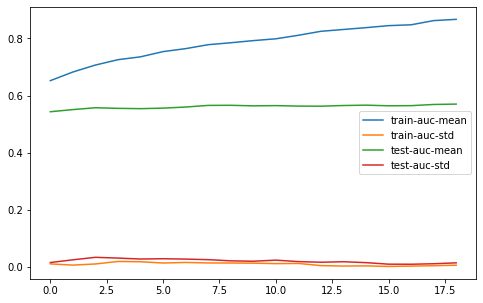

In [62]:
ax = cv_scores.plot(figsize=(8,5))

In [205]:
# select features
drop_features = ['death_in_next_window', 'window_id', 'person_id']

X = train.drop(drop_features, axis = 1)
train_features = X.columns.values
y = train.death_in_next_window
X = np.array(X)
y = np.array(y).ravel()

In [208]:
train

,race_concept_id,ethnicity_concept_id,race_concept_name,person_id,visit_duration,death_in_next_window,number_of_visits,gender_concept_id,old,visit_concept_name,...,observation_concept_id_list_40757059,observation_concept_id_list_4081756,observation_concept_id_list_4176605,observation_concept_id_list_4186037,observation_concept_id_list_4192270,observation_concept_id_list_4214956,observation_concept_id_list_43021378,observation_concept_id_list_4305831,observation_concept_id_list_433942,observation_type_concept_id_list_38000282
0,8552.0,0.0,4,0,0,False,4,8507,84,0,...,False,False,False,False,False,True,False,False,False,True
1,8560.0,0.0,3,5,0,False,1,8507,72,1,...,False,False,False,False,False,False,False,False,False,False
2,8528.0,0.0,5,6,0,False,3,8532,31,0,...,False,False,False,False,False,False,False,False,False,True
3,8552.0,38003564.0,4,10,0,False,1,8532,71,0,...,False,False,False,False,False,False,False,False,False,False
4,8512.0,0.0,2,12,0,False,2,8532,88,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278993,0.0,0.0,4,151476,0,False,1,8532,74,0,...,False,False,False,False,False,False,False,False,False,False
278994,8512.0,38003564.0,1,151533,0,False,2,8507,78,1,...,False,False,False,False,False,False,False,False,False,False
278995,8552.0,0.0,4,151550,0,False,1,8507,70,0,...,False,False,False,False,False,False,False,False,False,False
278996,0.0,0.0,4,151576,0,False,1,8532,79,0,...,False,False,False,False,False,False,False,False,False,True


In [35]:
# %%time

# # I can't use the sklearn API because I get this error: ValueError: y contains previously unseen labels: 29

# from sklearn.model_selection import StratifiedKFold

# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

# clf = xgb.XGBClassifier(**params)

# for i, (train_index, valid_index) in enumerate(cv.split(X, y)):
#     X_train, X_valid = X[train_index], X[valid_index]
#     y_train, y_valid = y[train_index], y[valid_index]

#     evals_result ={}

#     clf.fit(X_train, y_train, eval_set=[(X_valid),(y_valid)],
#             early_stopping_rounds=early_stop, verbose=False,
#             callbacks=[ xgb_progressbar(num_round),]) # use either the progress bar or the plot
#                                      # plot_perf_i(evals_result)]) 

#     print("Best Score:%f, best iteration:%d, best ntree:%d" % 
#           (xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))

## Train on StratifiedShuffleSPlit 20%

In [77]:
# just try the first window 
X = train
y = X.death_in_next_window
X = X.drop(drop_features, axis = 1)
train_features = X.columns.values
X = np.array(X)
y = np.array(y).ravel()

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)

for train_index, valid_index in sss.split(X, y):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

xgb_model = None
evals_result ={}
# Convert our data into XGBoost format
d_train = xgb.DMatrix(X_train, y_train, feature_names=train_features)
d_valid = xgb.DMatrix(X_valid, y_valid,  feature_names=train_features)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

In [78]:
xgb_model = xgb.train(params=params, dtrain=d_train, num_boost_round=num_round, 
                          evals=watchlist, evals_result=evals_result, 
                          early_stopping_rounds=early_stop, verbose_eval=False,
                          callbacks=[ xgb_progressbar(num_round),])

In [79]:
print("Best Score:%f, best iteration:%d, best ntree:%d" % 
      (xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))

Best Score:0.630545, best iteration:33, best ntree:34


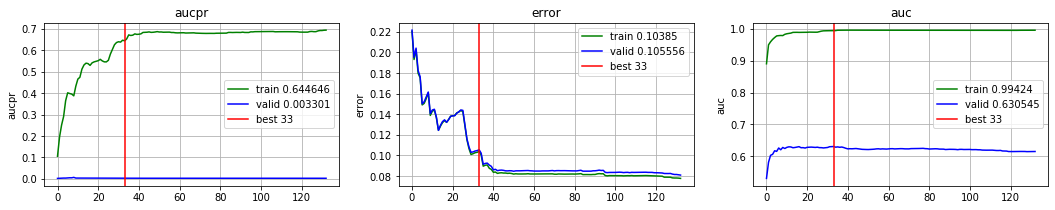

In [80]:
plot_perf(evals_result, xgb_model.best_iteration)

## RandomomizedSearchCV
 - https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

In [41]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

In [42]:
drop_features = ['death_in_next_window', 'window_id', 'person_id']
X = train
y = X.death_in_next_window
X = X.drop(drop_features, axis = 1)
train_features = X.columns.values
X = np.array(X)
y = np.array(y).ravel()

In [59]:
%%time
imbalance = int(round(train.shape[0] / train.death_in_next_window.sum()))
random_state = 1234
num_round = 500
early_stop = round(num_round / 5)  # 20% of the full rounds
metrics = ['auc']                   # faster with fewer metrics to calc
# metrics = ['aucpr','error', 'auc']

space = {
    'objective':['binary:logistic'],   # in this column are values I have tried
    'booster': ['gbtree'],
    'eval_metric': ['auc'],
    'tree_method' : ['gpu_hist'],
    'random_state' : [random_state],
    'learning_rate': [0.05],           # so called `eta` value
    'reg_lambda' : [1.0],
    'min_child_weight' : [1.0],
    'max_bin' : [256],                 # [50,100,256,500]
    'min_split_loss' : [0.01],
    'max_depth' : [15],                # [10,15,20]
    'reg_alpha' : [0.0],
    'colsample_bylevel' : [1.0],
    'scale_pos_weight' : [imbalance],  # [1,round(imbalance/2),imbalance],
    'max_delta_step' : [0.0],
    'learning_rate' : [0.05],
    'n_estimators' : [1000],
    'num_parallel_tree' : [1],
    'colsample_bytree' : [0.7],        # [0.5,0.7,0.8]
    'subsample' : [1.0],               # [0.8,1.0],
    'missing': [0],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
xgb_model = xgb.XGBClassifier()
# early_stopping = lambda: early_stopping_rounds=20
clf = RandomizedSearchCV(xgb_model, space, n_jobs=-1, cv=cv, scoring='roc_auc', verbose=2, refit=True, return_train_score=True)
clf.fit(X, y)

/home/user/anaconda3/envs/lgbm/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  3.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.3min finished


CPU times: user 35.6 s, sys: 8.87 s, total: 44.5 s
Wall time: 3min 51s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1234, shuffle=True),
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='bi...
                                        'min_split_loss': [0.01],
                                        'missing': [0], 'n_estimators': [1000],
                                        'num_parallel_tree': [1],
                                  

In [60]:
results = pd.DataFrame(clf.cv_results_['params'])
results['test_means']  = clf.cv_results_['mean_test_score']
results['test_stds']   = clf.cv_results_['std_test_score']*2
results['train_means'] = clf.cv_results_['mean_train_score']
results['train_stds']  = clf.cv_results_['std_train_score']*2
skip_col = [c for c in results.columns if len(results[c].unique()) == 1]
display(results[results.columns.difference(skip_col)].sort_values(by='test_means', ascending=False))
print("Best parameters: ", clf.best_params_)

,max_bin,test_means,test_stds,train_means,train_stds
0,256,0.582683,0.033186,0.999861,0.000014
1,500,0.580350,0.051991,0.999861,0.000013


Best parameters:  {'tree_method': 'gpu_hist', 'subsample': 1.0, 'scale_pos_weight': 499, 'reg_lambda': 1.0, 'reg_alpha': 0.0, 'random_state': 1234, 'objective': 'binary:logistic', 'num_parallel_tree': 1, 'n_estimators': 1000, 'missing': 0, 'min_split_loss': 0.01, 'min_child_weight': 1.0, 'max_depth': 15, 'max_delta_step': 0.0, 'max_bin': 256, 'learning_rate': 0.05, 'eval_metric': 'auc', 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'booster': 'gbtree'}


In [50]:
print("Best parameters: ", clf.best_params_)
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#           % (mean, std * 2, params))
# pd.DataFrame([mean, stds *2])
results = pd.DataFrame(clf.cv_results_['params'])
# [c for c in results.columns if len(results[c].unique()) == 1]
skip_col = []
for c in results.columns:
    if len(results[c].unique()) == 1:  #doesn't work if c contains a list
        skip_col.append(c)

results['means'] = means
results['stds'] = stds
results[results.columns.difference(skip_col)].sort_values(by='means', ascending=False)

Best parameters:  {'tree_method': 'gpu_hist', 'subsample': 1.0, 'scale_pos_weight': 499, 'reg_lambda': 1.0, 'reg_alpha': 0.0, 'random_state': 1234, 'objective': 'binary:logistic', 'num_parallel_tree': 1, 'n_estimators': 1000, 'missing': 0, 'min_split_loss': 0.01, 'min_child_weight': 1.0, 'max_depth': 15, 'max_delta_step': 0.0, 'max_bin': 256, 'learning_rate': 0.05, 'eval_metric': 'auc', 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'booster': 'gbtree'}
Grid scores on development set:


,colsample_bytree,max_depth,means,scale_pos_weight,stds
1,0.7,15,0.582683,499,0.016593
7,0.8,20,0.581527,499,0.015440
0,0.7,15,0.580834,1,0.014327
5,0.8,15,0.580063,499,0.017455
4,0.8,15,0.575856,1,0.012855
6,0.8,20,0.575194,1,0.014848
2,0.7,20,0.574377,1,0.014440
3,0.7,20,0.574231,499,0.019418


## SKOpt

In [53]:
# !pip install scikit-optimize

In [54]:
# import skopt
# skopt.__version__

In [55]:
# X = train[train.window_id == 1]
# y = X.death_in_next_window
# X = X.drop(drop_features, axis = 1)
# train_features = X.columns.values
# X = np.array(X)
# y = np.array(y).ravel()

In [56]:
# random_state = 1234
# num_round = 500
# early_stop = round(num_round / 5)  # 20% of the full rounds
# metrics = 'auc'                  # faster with fewer metrics to calc
# #metrics = ['aucpr','error', 'auc']

# params = {
#     'objective': 'binary:logistic',
#     'booster': 'gbtree',
#     'eval_metric': metrics,
#     'tree_method' : 'auto',  # set to 'auto' if no gpu - other options 'gpu_hist', 'hist', 'exact' # gpu_hist fails with a SIGSEGV 11
#     'random_state' : random_state,
# }
# params

In [57]:
# # https://www.kaggle.com/nanomathias/bayesian-optimization-of-xgboost-lb-0-9769

# from skopt import BayesSearchCV
# # Classifier
# bayes_cv_tuner = BayesSearchCV(
#     estimator = xgb.XGBClassifier(**params),
#     search_spaces = {
#         'learning_rate': (0.01, 1.0, 'log-uniform'),
#         'min_child_weight': (0, 10),
#         'max_depth': (0, 50),
#         'max_delta_step': (0, 20),
#         'subsample': (0.01, 1.0, 'uniform'),
#         'colsample_bytree': (0.01, 1.0, 'uniform'),
#         'colsample_bylevel': (0.01, 1.0, 'uniform'),
#         'reg_lambda': (1e-9, 1000, 'log-uniform'),
#         'reg_alpha': (1e-9, 1.0, 'log-uniform'),
#         'gamma': (1e-9, 0.5, 'log-uniform'),
#         'min_child_weight': (0, 5),
#         'n_estimators': (50, 100),
#         'scale_pos_weight': (1e-6, 500, 'log-uniform')
#     },    
#     scoring = 'roc_auc',
#     cv = StratifiedKFold(
#         n_splits=3,
#         shuffle=True,
#         random_state=random_state
#     ),
#     n_jobs = -1,
#     n_iter = 500,   
#     verbose = 1,
#     refit = True,
#     random_state = random_state
# )

# def status_print(optim_result):
#     """Status callback durring bayesian hyperparameter search"""
    
#     # Get all the models tested so far in DataFrame format
#     all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
#     # Get current parameters and the best parameters    
#     best_params = pd.Series(bayes_cv_tuner.best_params_)
#     print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
#         len(all_models),
#         np.round(bayes_cv_tuner.best_score_, 4),
#         bayes_cv_tuner.best_params_
#     ))
    
#     # Save all model results
#     clf_name = bayes_cv_tuner.estimator.__class__.__name__
# #    all_models.to_csv(clf_name+"_cv_results.csv")

In [58]:
# # Fit the model
# # Fails at model 10 with: ValueError: All integer values shouldbe greater than 0.000000
# result = bayes_cv_tuner.fit(X, y, callback=status_print)

## Hyperopt

In [59]:
# !pip install hyperopt

In [27]:
from hyperopt.plotting import main_plot_history, main_plot_histogram
from hyperopt import hp, fmin, atpe, tpe, Trials, STATUS_OK, STATUS_FAIL
from sklearn.metrics import roc_auc_score, auc

In [28]:
imbalance = int(round(train.shape[0] / train.death_in_next_window.sum()))
imbalance

499

In [55]:
# https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

# XGB parameters
xgb_reg_params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'tree_method' : 'hist',  # set to 'auto' if no gpu - other options 'gpu_hist', 'hist', 'exact'
    'learning_rate':    0.05, # hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(10, 30, 10, dtype=int)),
#    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
#    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
#    'subsample':        hp.uniform('subsample', 0.8, 1),
#    'n_estimators':     400,
    'scale_pos_weight' : hp.choice('scale_pos_weight', [1,10,round(imbalance/2), imbalance]),

}

xgb_fit_params = {
    'eval_metric': 'auc',
    'early_stopping_rounds': 20,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: 1.0-roc_auc_score(y, pred)

In [49]:
class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL, 'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBClassifier(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [50]:
# just try the first window 
X = train
y = X.death_in_next_window
X = X.drop(drop_features, axis = 1)
train_features = X.columns.values
X = np.array(X)
y = np.array(y).ravel()

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)

for train_index, valid_index in sss.split(X, y):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

In [51]:
obj = HPOpt(X_train, X_valid, y_train, y_valid)

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=4)

100%|██████████| 4/4 [01:08<00:00, 17.13s/trial, best loss: 0.4889537628009112] 


avg best error: 0.4889537628009112


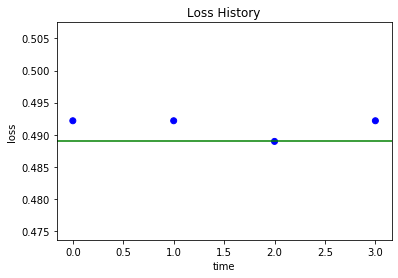

In [52]:
main_plot_history(xgb_opt[1])

Showing Histogram of 4 jobs


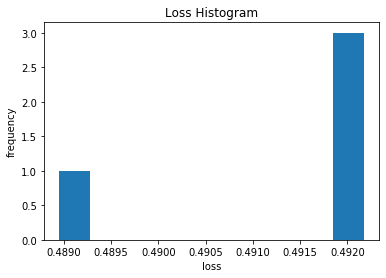

In [53]:
main_plot_histogram(xgb_opt[1])

In [54]:
xgb_opt

({'scale_pos_weight': 1}, <hyperopt.base.Trials at 0x7f5529374090>)

In [67]:
# # Define objective function
# def objective(x):
#     return {'loss': 1 - auc, 'status': STATUS_OK}

# # Run hyperopt optimization
# trials = Trials()
# result = fmin(
#     fn=objective,               
#     space=hp.uniform('x', -1, 1),   # parameter space
#     algo=tpe.suggest,               # surrogate algorithm
#     max_evals=500,                  # no. of evaluations
#     trials=trials                   # trials object that keeps track of the sample results (optional)
# )

# # Print the optimized parameters
# print(result)

# # Extract and plot the trials 
# x = trials.vals['x']
# y = [x['loss'] for x in trials.results]
# plt.scatter(x, y)

## ROC AUC Curve

In [68]:
# X = train.drop(drop_features, axis = 1)
# train_features = X.columns.values
# y = train[['death_in_next_window']]
# X = np.array(X)
# y = np.array(y).ravel()

In [82]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)

for train_index, valid_index in sss.split(X, y):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

In [35]:
# Convert data into XGBoost format
d_train = xgb.DMatrix(X_train, y_train, feature_names=train_features)
d_valid = xgb.DMatrix(X_valid, y_valid, feature_names=train_features)

In [101]:
best_tree = xgb_model.best_ntree_limit
best_tree = 16
train_preds = xgb_model.predict(d_train, ntree_limit=best_tree)
valid_preds = xgb_model.predict(d_valid, ntree_limit=best_tree)

In [102]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import plot_roc_curve  # only sklearn after version 0.22 
from sklearn.metrics import precision_recall_curve
from scikitplot.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

In [103]:
print('Train AUC =',roc_auc_score(y_train, train_preds))
print('Valid AUC =',roc_auc_score(y_valid, valid_preds))

Train AUC = 0.4511737200075571
Valid AUC = 0.50912638469285


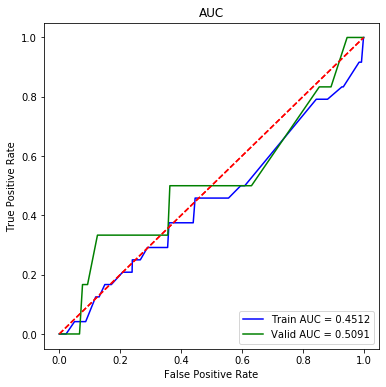

In [105]:
ax = buildROC(y_train, train_preds, label='Train')
ax = buildROC(y_valid, valid_preds, label='Valid', color='g')

## Feature Importance

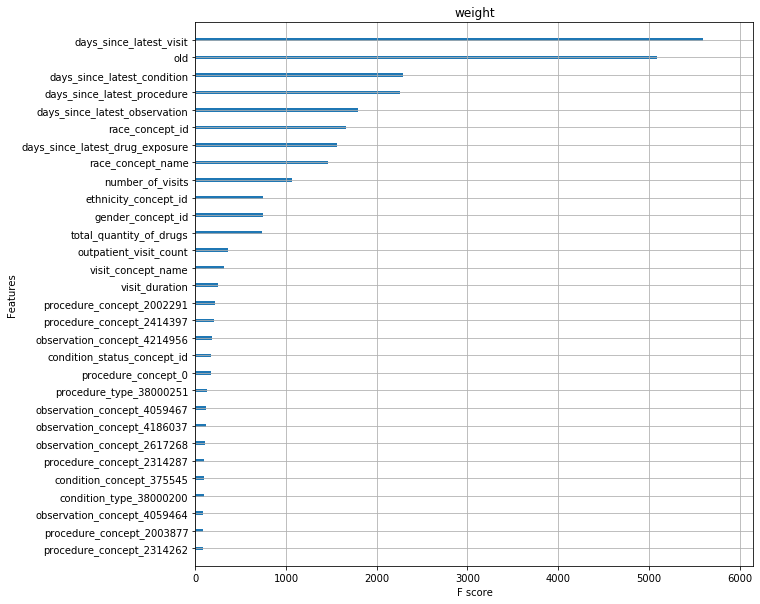

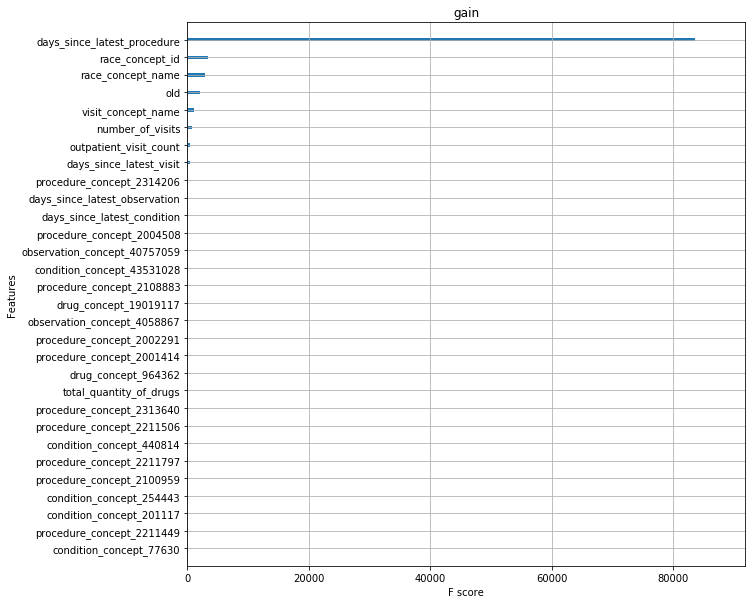

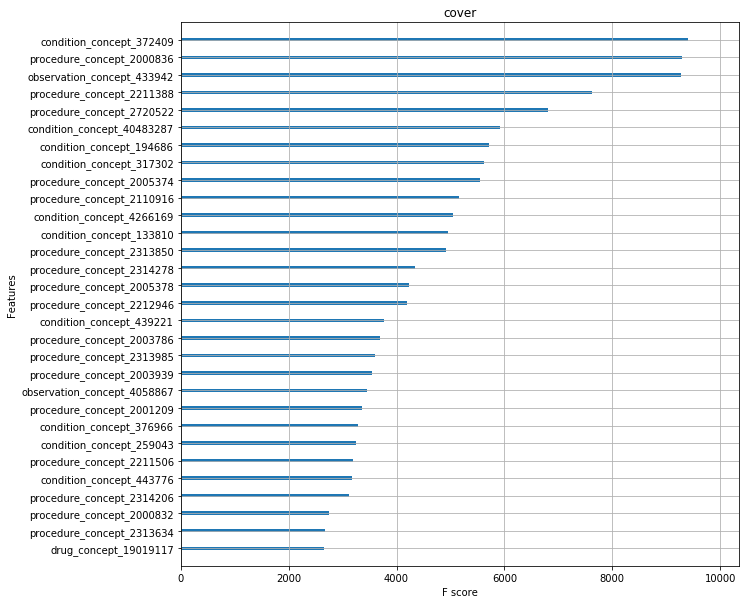

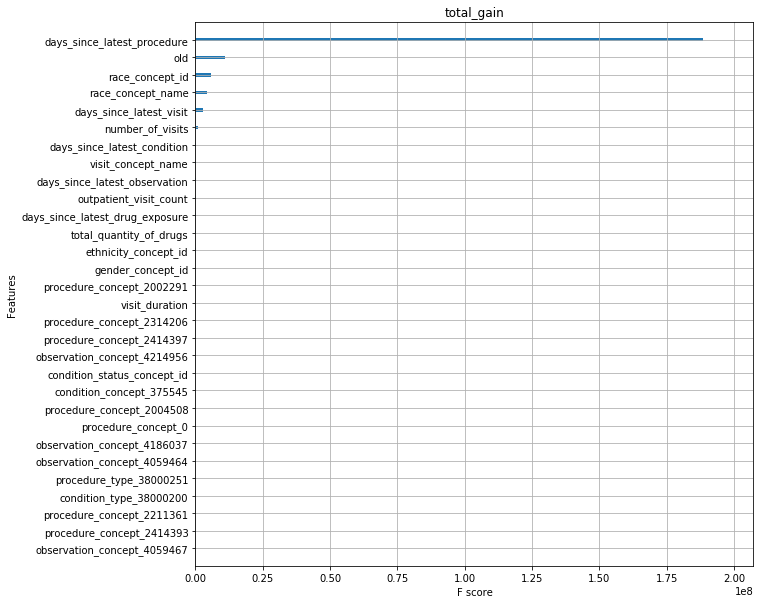

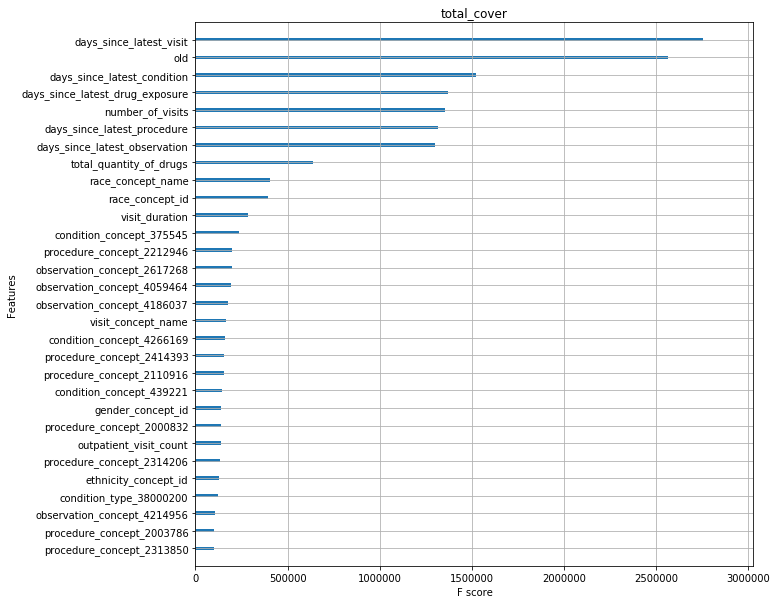

In [106]:
plt.rcParams["figure.figsize"] = (10,10)
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
for i in importance_types:
    ax = xgb.plot_importance(xgb_model, importance_type=i, max_num_features=30, title=i, show_values=False)

In [107]:
for idx, i in enumerate(importance_types):
    i_dict = xgb_model.get_score(importance_type=i)
    i_df = pd.DataFrame.from_dict(i_dict.items())
    i_df.columns=['feature',i]
    if idx == 0:
        importance = i_df
    else:
        importance = importance.combine_first(i_df) #, on='feature', how='outer', suffixes=(False, False))

importance = importance.set_index('feature')
importance = importance[importance_types]
importance = importance.sort_values(by='weight', ascending=False)
importance = importance.round(2)
importance.head(10)

,weight,gain,cover,total_gain,total_cover
feature,,,,,
days_since_latest_visit,5594,506.36,492.15,2.832589e+06,2753064.21
old,5085,2147.92,504.85,1.092219e+07,2567174.49
days_since_latest_condition,2293,157.63,664.14,3.614517e+05,1522867.28
days_since_latest_procedure,2254,83575.22,584.12,1.883786e+08,1316605.26
days_since_latest_observation,1790,158.55,726.42,2.837979e+05,1300293.46
race_concept_id,1664,3443.06,237.73,5.729253e+06,395590.87
days_since_latest_drug_exposure,1560,58.81,877.18,9.175101e+04,1368404.50
race_concept_name,1460,2929.29,276.35,4.276762e+06,403467.01
number_of_visits,1066,778.58,1271.60,8.299629e+05,1355522.78


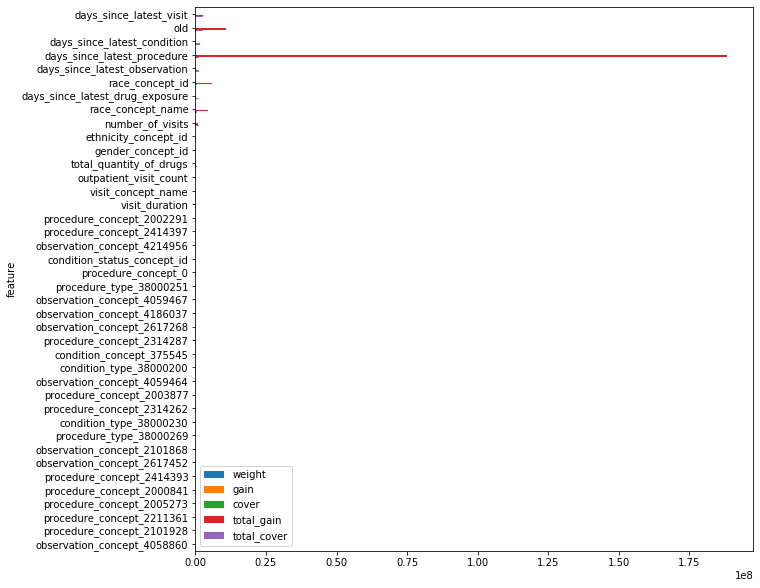

In [108]:
ax = importance[:40].plot.barh()
ax.invert_yaxis()

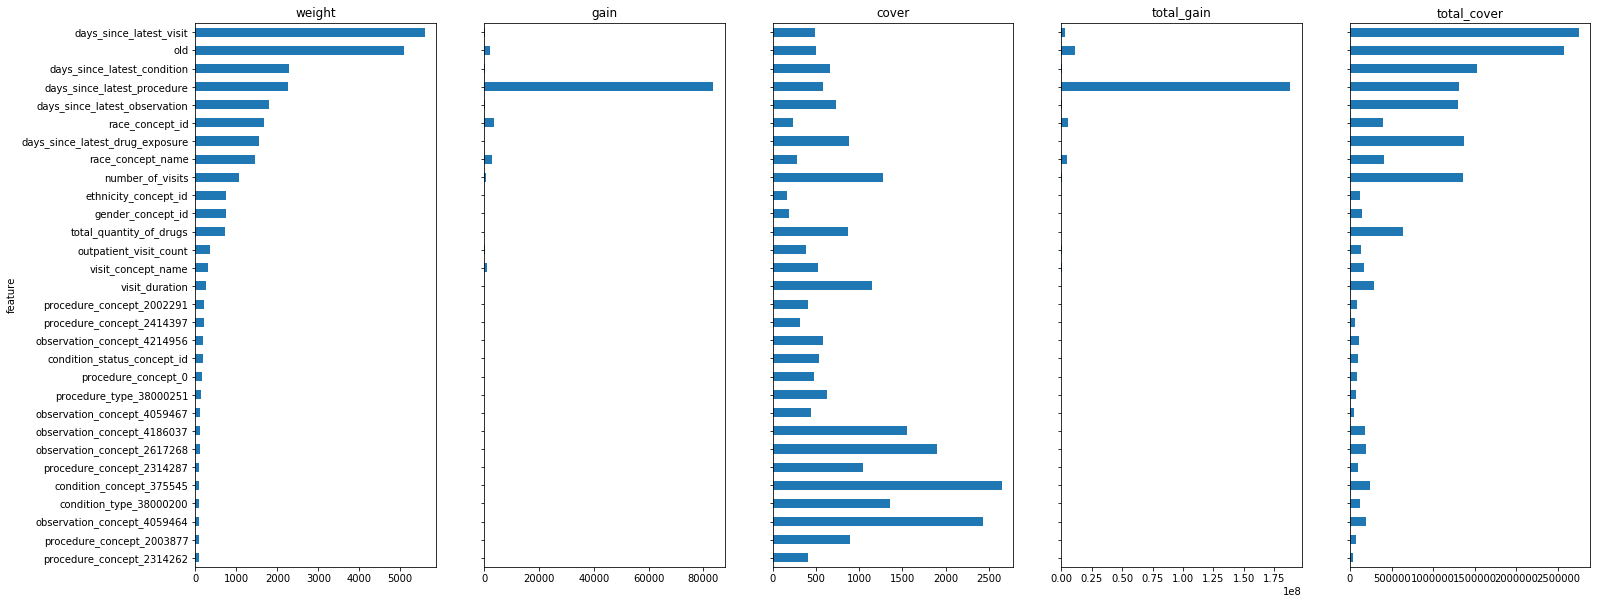

In [109]:
fig, axs = plt.subplots(1, len(importance_types), sharey=True, figsize=(len(importance_types)*5,10))
for idx, i in enumerate(importance_types):
    importance[i][:30].plot.barh(title=i, ax=axs[idx])
    axs[idx].invert_yaxis()
plt.show()

In [110]:
importance = importance.join(col_concepts.set_index('column'),how='left') #.sort_values(by='weight', ascending=False)
importance[:50]

,weight,gain,cover,total_gain,total_cover,concept_name,vocabulary_id,table
feature,,,,,,,,
days_since_latest_visit,5594,506.36,492.15,2.832589e+06,2753064.21,NaN,NaN,NaN
old,5085,2147.92,504.85,1.092219e+07,2567174.49,NaN,NaN,NaN
days_since_latest_condition,2293,157.63,664.14,3.614517e+05,1522867.28,NaN,NaN,NaN
days_since_latest_procedure,2254,83575.22,584.12,1.883786e+08,1316605.26,NaN,NaN,NaN
days_since_latest_observation,1790,158.55,726.42,2.837979e+05,1300293.46,NaN,NaN,NaN
race_concept_id,1664,3443.06,237.73,5.729253e+06,395590.87,NaN,NaN,NaN
days_since_latest_drug_exposure,1560,58.81,877.18,9.175101e+04,1368404.50,NaN,NaN,NaN
race_concept_name,1460,2929.29,276.35,4.276762e+06,403467.01,NaN,NaN,NaN
number_of_visits,1066,778.58,1271.60,8.299629e+05,1355522.78,NaN,NaN,NaN


In [81]:
observation = pd.read_csv('v2/app/concept_codes_final/observation_concepts.csv')
observation.head()

,observation_concept_id,concept_name,vocabulary_id
0,313232,Hemodialysis-associated hypotension,SNOMED
1,432454,Excessive thirst,SNOMED
2,141693,Elevated blood-pressure reading without diagno...,SNOMED
3,379831,Unilateral neural hearing loss,SNOMED
4,433496,Unilateral sensory hearing loss,SNOMED


In [82]:
observation[observation.observation_concept_id == 4058860]

,observation_concept_id,concept_name,vocabulary_id


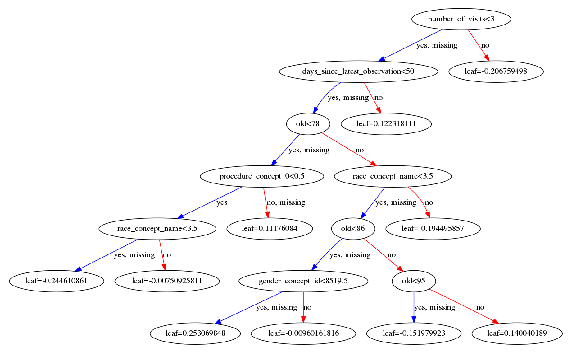

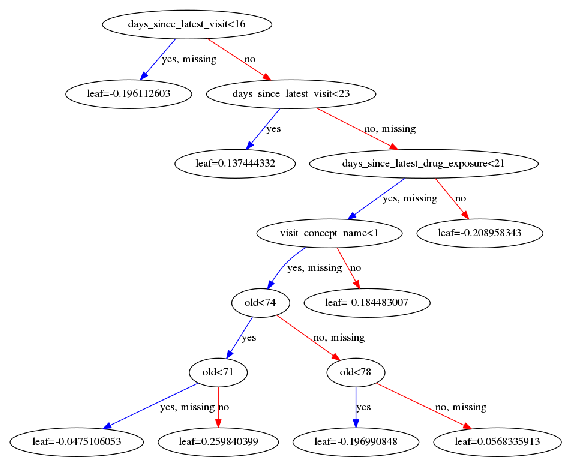

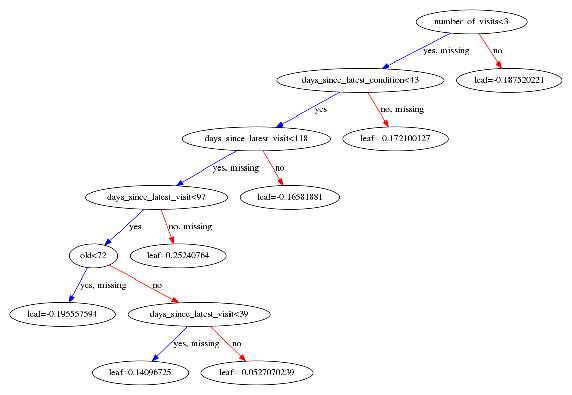

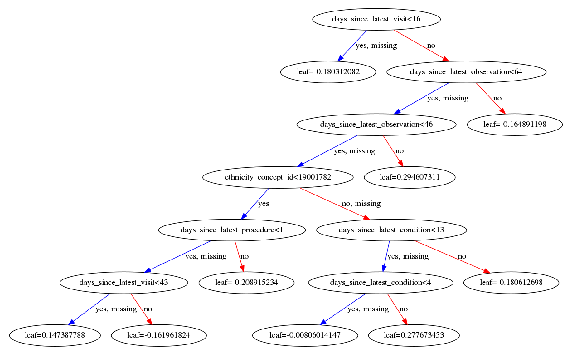

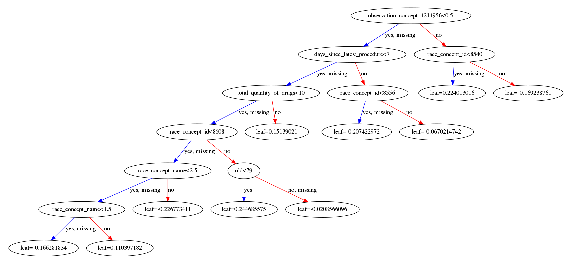

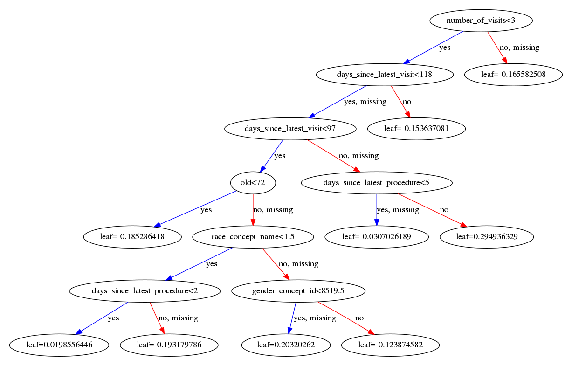

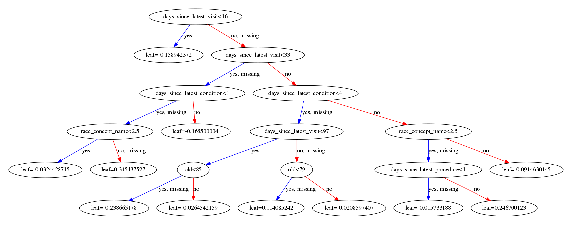

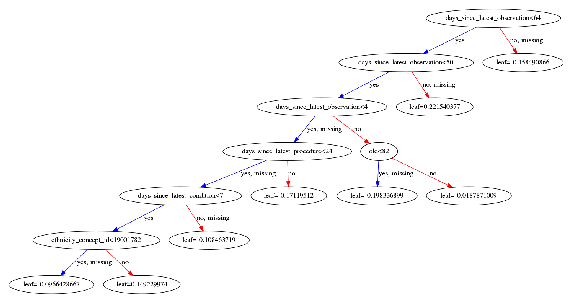

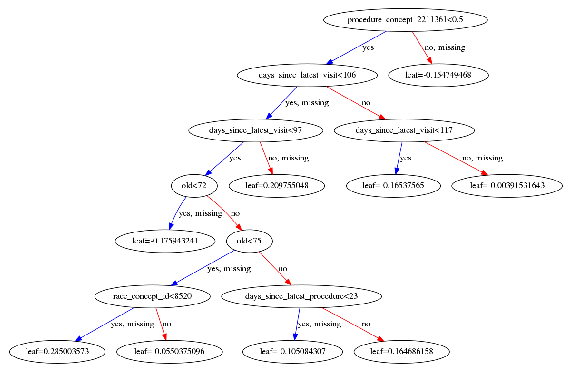

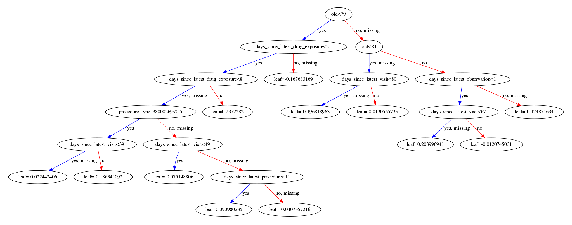

In [83]:
for k in range(30,40):
    ax = xgb.plot_tree(xgb_model,num_trees=k)
    plt.show()

In [ ]:
raise Exception('STOP HERE - NOTHING WORKS PAST THIS POINT')

## SHAP explanations - doesn't work, tree too big
-  https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

In [103]:
# # # !pip install shap
# import shap
# shap.__version__

'0.34.0'

In [104]:
# X = train[train.window_id == w] #[train.columns[:50]]
# y = X.death_in_next_window
# X = X.drop(drop_features, axis = 1)
# train_features = X.columns.values
# X = np.array(X)
# y = np.array(y).ravel()

In [1]:
# explainer = shap.TreeExplainer(xgb_model)

In [2]:
# shap_values = explainer.shap_values(X)

In [5]:
# # visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

## LGBM

In [32]:
random_state = 1234
num_round = 500
early_stop = round(num_round / 5)  # 20% of the full rounds
metrics = 'auc'                   # faster with fewer metrics to calc
# metrics = ['aucpr','error', 'auc']

params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': metrics,
    'tree_method' : 'gpu_hist',  # set to 'auto' if no gpu - other options 'gpu_hist', 'hist', 'exact'
    'random_state' : random_state,
}

In [39]:
window = {}
xgb_model = None # clear out the xgb_model
for w in train.window_id.unique():
    X = train[train.window_id == w] #[train.columns[:50]]
    y = X.death_in_next_window
    window[w] = {'size': y.shape[0], 'deaths': y.sum()}
    X = X.drop(drop_features, axis = 1)
    train_features = X.columns.values
    X = np.array(X)
    y = np.array(y).ravel()
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
    cv_scores = {}
    for i, (train_index, valid_index) in enumerate(cv.split(X, y)):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        evals_result ={}
        # Convert our data into XGBoost format
        d_train = xgb.DMatrix(X_train, y_train, feature_names=train_features)
        d_valid = xgb.DMatrix(X_valid, y_valid,  feature_names=train_features)
    break

In [46]:
import lightgbm as lgb

params = {
    'num_leaves': 31,
    'learning_rate': 0.05,
    'n_estimators': 20,
}

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': ['binary_logloss','auc'],
    'n_estimators': 20,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}

gbm = lgb.LGBMClassifier(**params)

gbm.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_valid, y_valid)],
#        eval_metric='auc',
        early_stopping_rounds=10)

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration_)
# eval
print('AUC: ', roc_auc_score(y_valid, y_pred))


[1]	training's binary_logloss: 0.0028781	training's auc: 0.881121	valid_1's binary_logloss: 0.00503981	valid_1's auc: 0.585565
Training until validation scores don't improve for 10 rounds
[2]	training's binary_logloss: 0.00251488	training's auc: 0.884573	valid_1's binary_logloss: 0.00504291	valid_1's auc: 0.369379
[3]	training's binary_logloss: 0.00237696	training's auc: 0.872186	valid_1's binary_logloss: 0.00503983	valid_1's auc: 0.321603
[4]	training's binary_logloss: 0.00224399	training's auc: 0.874452	valid_1's binary_logloss: 0.00502861	valid_1's auc: 0.305183
[5]	training's binary_logloss: 0.00213662	training's auc: 0.86582	valid_1's binary_logloss: 0.00501707	valid_1's auc: 0.326683
[6]	training's binary_logloss: 0.0018867	training's auc: 0.999294	valid_1's binary_logloss: 0.00562455	valid_1's auc: 0.350915
[7]	training's binary_logloss: 0.00175192	training's auc: 0.999731	valid_1's binary_logloss: 0.00559842	valid_1's auc: 0.367446
[8]	training's binary_logloss: 0.00164644	trai

In [41]:
gbm.feature_importances_

array([7, 0, 3, 1, 1, 2, 0, 1, 4, 0, 0, 0, 0, 0, 3, 0, 2, 2, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

## CatBoost

## Eval Test 

In [98]:
# Predict on test data
d_test = xgb.DMatrix(X_test, y_test, feature_names=test_features)
preds = xgb_model.predict(d_test, ntree_limit=xgb_model.best_ntree_limit)

In [99]:
y_scores = preds

In [100]:
print('AUC =',roc_auc_score(y_test.values, y_scores))

AUC = 0.581584987257072


In [101]:
average_precision = average_precision_score(y_test, y_scores)
print('PRAUC = ', average_precision)

PRAUC =  0.001821919286533311


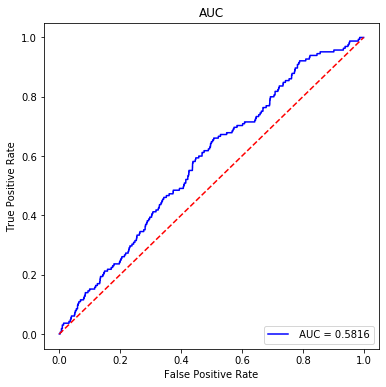

In [102]:
buildROC(y_test.values, preds, label='')

In [72]:
# # only good with sklearn API

# fig, ax = plt.subplots()
# plot_roc_curve(xgb_model, X_test, y_test, ax=ax)
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#         label='Chance', alpha=.8)

# ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
#        title="AUC")
# ax.legend(loc="lower right")
# plt.show()

In [ ]:
# !pip install scikit-plot

In [65]:
# import scikitplot as skplt
# plt.rcParams["figure.figsize"] = (10,10)
# skplt.metrics.plot_roc(y_test, preds)

## Full train

In [61]:
# select features
drop_features = ['death_in_next_window', 'window_id', 'person_id']

X = train.drop(drop_features, axis = 1)
train_features = X.columns.values
y = train.death_in_next_window
X = np.array(X)
y = np.array(y).ravel()

In [66]:
imbalance = int(round(train.shape[0] / train.death_in_next_window.sum()))
random_state = 1234
num_round = 56
early_stop = round(num_round / 5)  # 20% of the full rounds
metrics = ['auc']                   # faster with fewer metrics to calc
metrics = ['aucpr','error', 'auc']

params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': metrics,
    'tree_method' : 'gpu_hist',  # set to 'auto' if no gpu - other options 'gpu_hist', 'hist', 'exact'
    'random_state' : random_state,
    'reg_lambda' : 1.0,
    'min_child_weight' : 1.0,
    'max_bin' : 256,
    'min_split_loss' : 0.01,
    'max_depth' : 15,
    'reg_alpha' : 0.0,
    'colsample_bylevel' : 1.0,
    'scale_pos_weight' : 500,
    'max_delta_step' : 0.0,
    'learning_rate' : 0.05,
    'n_estimators' : 1000,
    'num_parallel_tree' : 1,
    'colsample_bytree' : 0.7,
    'subsample' : 1.0,
    'missing': 0,
}

In [67]:
df_preds = pd.DataFrame()
evals_result ={}

d_train_full = xgb.DMatrix(X, y, feature_names=train_features)
watchlist = [(d_train_full, 'train_full')]

xgb_model = xgb.train(params, d_train_full, num_round, watchlist,
                      early_stopping_rounds=50, maximize=True, 
                      verbose_eval=False, callbacks=[xgb_progressbar(num_round), ])

print(xgb_model.best_score, xgb_model.best_ntree_limit)

0.982633 38


In [64]:
model_file = 'xgb_model.joblib'
dump(xgb_model, model_file)

['xgb_model.joblib']

In [65]:
xgb_model_2 = load(model_file)
type(xgb_model_2)

xgboost.core.Booster